In [15]:
import numpy as np # linear algebra
np.random.seed(666)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

sample_submission.csv
test.json
train.json



In [16]:
#Load data
train = pd.read_json("../input/train.json")
test = pd.read_json("../input/test.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
print("done!")

done!


In [17]:
# Train data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

# Test data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_test = np.array(test.inc_angle)


X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train
                    , X_angle_train, y_train, random_state=123, train_size=0.75)

In [18]:
X_train.shape

(1203, 75, 75, 3)

In [19]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import matplotlib.pyplot as plt

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
    
def get_model():
    bn_model = 0
    p_activation = "elu"
    input_1 = Input(shape=(75, 75, 3), name="X_1")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = GlobalMaxPooling2D() (img_1)
    
    
    img_2 = Conv2D(128, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.2)(img_2)
    img_2 = GlobalMaxPooling2D() (img_2)
    
    img_concat =  (Concatenate()([img_1, img_2, BatchNormalization(momentum=bn_model)(input_2)]))
    
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(256, activation=p_activation)(img_concat) ))
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(64, activation=p_activation)(dense_ayer) ))
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model([input_1,input_2],  output)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_1 (InputLayer)                (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 75, 75, 3)    12          X_1[0][0]                        
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 73, 73, 16)   448         batch_normalization_21[0][0]     
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 71, 71, 16)   2320        conv2d_33[0][0]                  
__________________________________________________________________________________________________
max_poolin

Train on 1203 samples, validate on 401 samples
Epoch 1/20
1203/1203 [==============================] - 29s 24ms/step - loss: 0.8423 - acc: 0.6185 - val_loss: 0.5396 - val_acc: 0.7357
Epoch 2/20
1203/1203 [==============================] - 27s 22ms/step - loss: 0.6599 - acc: 0.7132 - val_loss: 0.4024 - val_acc: 0.7980
Epoch 3/20
1203/1203 [==============================] - 26s 22ms/step - loss: 0.5293 - acc: 0.7623 - val_loss: 0.4255 - val_acc: 0.8155
Epoch 4/20
1203/1203 [==============================] - 27s 22ms/step - loss: 0.4132 - acc: 0.8238 - val_loss: 0.4312 - val_acc: 0.8429
Epoch 5/20
1203/1203 [==============================] - 26s 22ms/step - loss: 0.3853 - acc: 0.8429 - val_loss: 0.4244 - val_acc: 0.8329
Epoch 6/20
1203/1203 [==============================] - 27s 22ms/step - loss: 0.3659 - acc: 0.8387 - val_loss: 0.2985 - val_acc: 0.8878
Epoch 7/20
1203/1203 [==============================] - 27s 22ms/step - loss: 0.3540 - acc: 0.8479 - val_loss: 0.3388 - val_acc: 0.8603
E

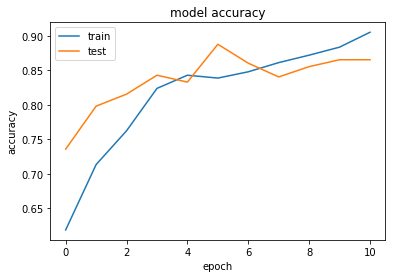

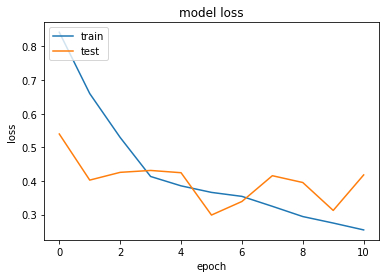

In [20]:
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

model = get_model()
history = model.fit([X_train, X_angle_train], y_train, epochs=20
          , validation_data=([X_valid, X_angle_valid], y_valid)
         , batch_size=32
         , callbacks=callbacks)

fig = plt.figure()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

fig.savefig('my_figure_1.png')




# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

fig.savefig('my_figure_2.png')

In [21]:
model.load_weights(filepath=file_path)

print("Train evaluate:")
print(model.evaluate([X_train, X_angle_train], y_train, verbose=1, batch_size=200))
print("####################")
print("watch list evaluate:")
print(model.evaluate([X_valid, X_angle_valid], y_valid, verbose=1, batch_size=200))

Train evaluate:
1203/1203 [==============================] - 8s 7ms/step
[0.21828909729454893, 0.9110556897379811]
####################
watch list evaluate:
401/401 [==============================] - 3s 7ms/step
[0.29846416513187035, 0.887780536737228]


In [22]:
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

8424/8424 [==============================] - 57s 7ms/step


In [23]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.head(10)

,id,is_iceberg
0,5941774d,0.029058
1,4023181e,0.134382
2,b20200e4,0.000014
3,e7f018bb,0.990017
4,4371c8c3,0.095560
5,a8d9b1fd,0.309528
6,29e7727e,0.048560
7,92a51ffb,0.985250
8,c769ac97,0.014928
9,aee0547d,0.007078


In [24]:
submission.to_csv("./submission.csv", index=False)